In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#Mô hình XG Boost
import xgboost as xgb
import lightgbm as lgb
#Mô hình Random Forrest
from sklearn.ensemble import RandomForestClassifier
#SMOTE
from imblearn.over_sampling import SMOTE
#MLP
from sklearn.neural_network import MLPClassifier
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
#SVM
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
data=pd.read_csv('cross-sale-data-train.csv')
data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


**Các đặc trưng của dữ liệu bao gồm:**

**Gender (Giới tính)** *Nam hoặc nữ*

**Age (Tuổi)** *Độ tuổi của người dùng*

**Driving_License (Bằng lái xe):** *Có (1) hoặc không (0)*

**Region_Code (Mã khu vực):** *Nơi người đó sống*

**Previously_Insured (Đã mua bảo hiểm chưa):** *Có (1) hoặc chưa (0)*

**Vehicle_Age (Tuổi của xe):** *Chia thành các độ tuổi*

**Vehicle_Damage (Hỏng hóc xe):** *Có (1) hoặc chưa (0)*

**Annual_Premium (Phí hàng năm):** *Số tiền phải trả hàng năm cho bảo hiểm xe*

**Policy_Sales_Channel (Kênh bán chính sách):** *Một con số hoặc mã đại diện cho kênh cụ thể.*

**Vintage:** *Thời gian tính bằng số ngày từ khi khách hàng trở thành khách hàng của công ty bảo hiểm.*

**Response (Phản hồi):** *Đầu ra: "1" là mua bảo hiểm mới hoặc "0" nếu không mua.*

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


***Thông qua ma trận biểu đồ, dễ thấy dữ liệu phân bổ Phi tuyến, vậy ta sẽ ưu tiên các mô hình Non-linear Classification***

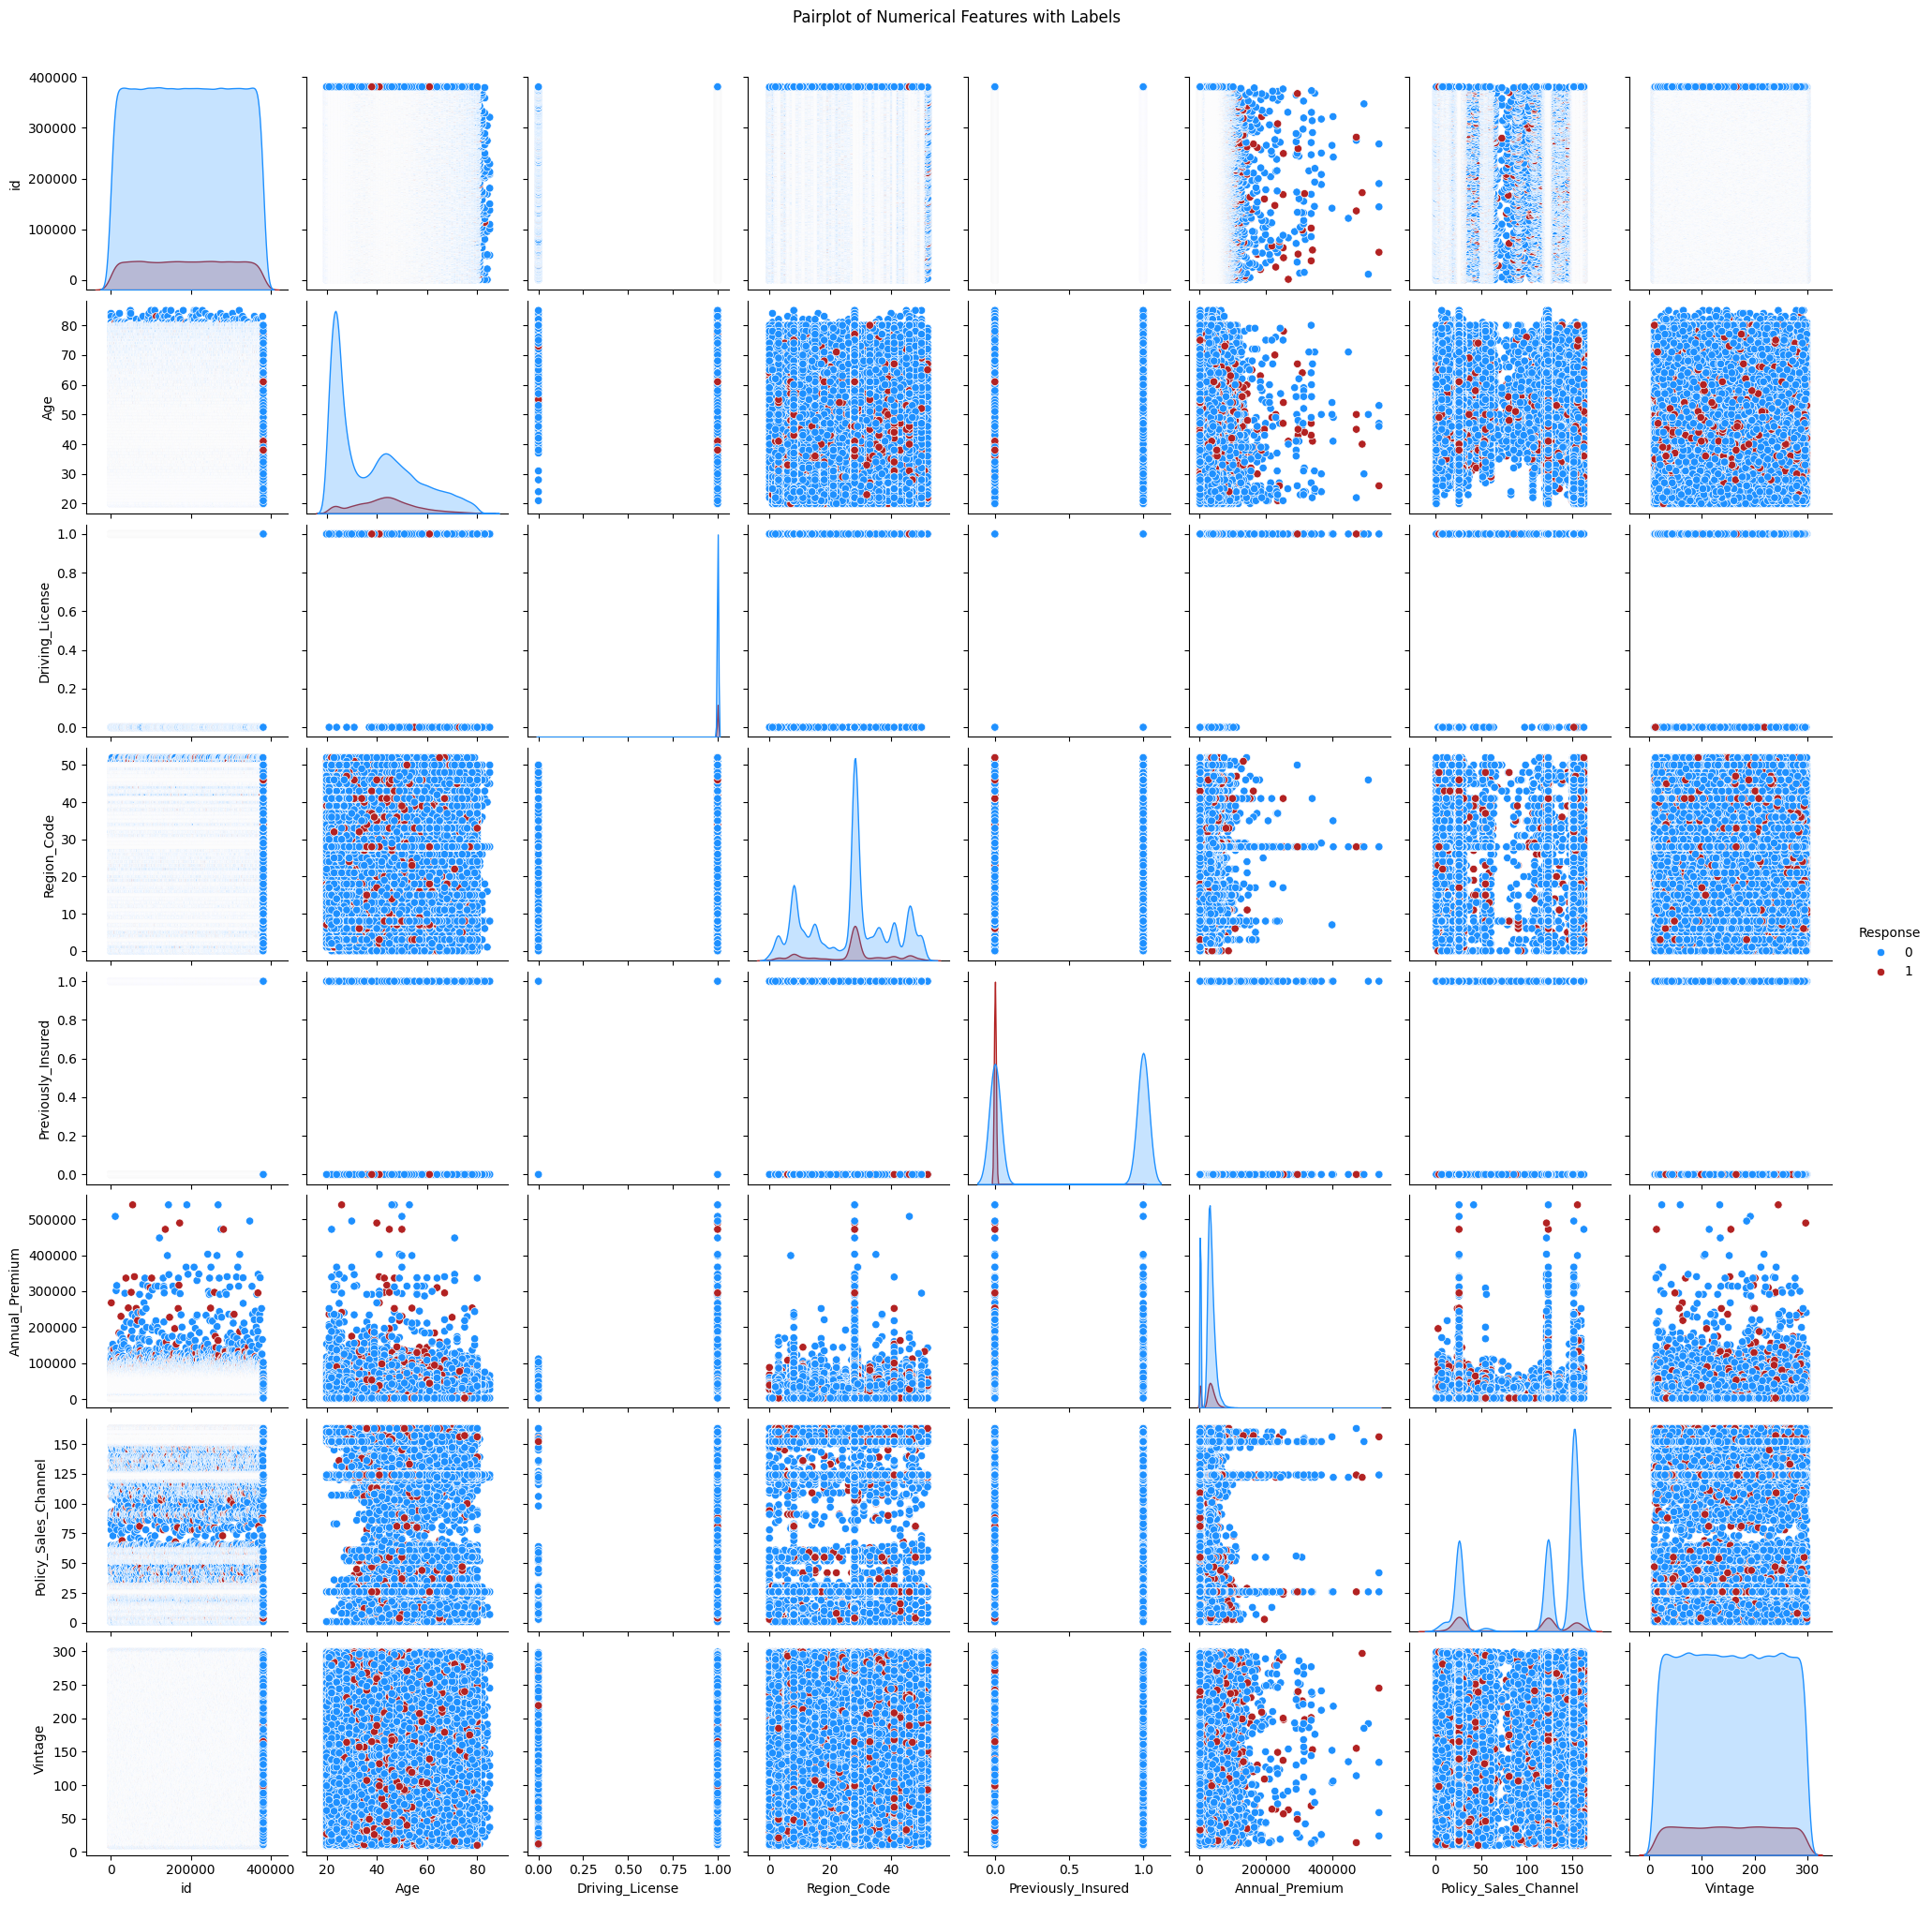

In [ ]:
scatter_cols = data.select_dtypes(exclude=['object']).columns
scatter_cols = scatter_cols.drop('Response')

data_subset = data[scatter_cols.tolist() + ['Response']]

# Vẽ matrix scatter plot
pair_plot = sns.pairplot(data_subset, hue='Response', palette={0: '#1E90FF', 1: '#B22222'})
pair_plot.fig.suptitle('Pairplot of Numerical Features with Labels', y=1.02)
plt.show()

**A.DATA CHECKING**

In [3]:
#Nhìn sơ bộ, ta thấy có 2 cột không cần thiết, vì vậy có thể xóa 2 cột này đi
data=data.drop(columns=["id", "Policy_Sales_Channel"])

In [ ]:
data['Region_Code'].value_counts()

Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64

In [4]:
#Ở cột Region_Code này, đại đa số đều rơi vào 28, vì vậy, ta có thể tổng hợp tất cả các giá trị "khác 28" vào làm một
data["Region_Code"] = data["Region_Code"].apply(lambda x: 1 if x==28 else 0)

**B.EDA**

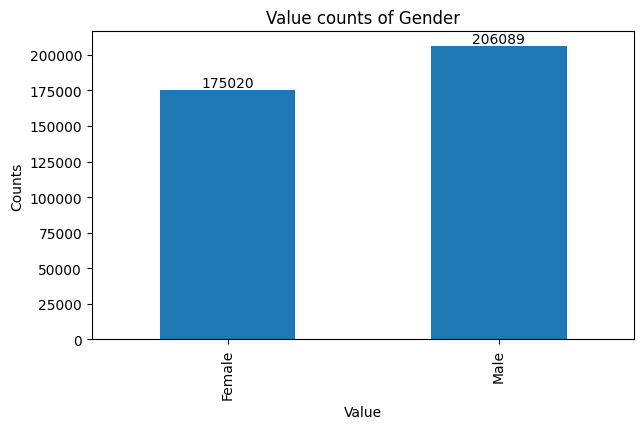

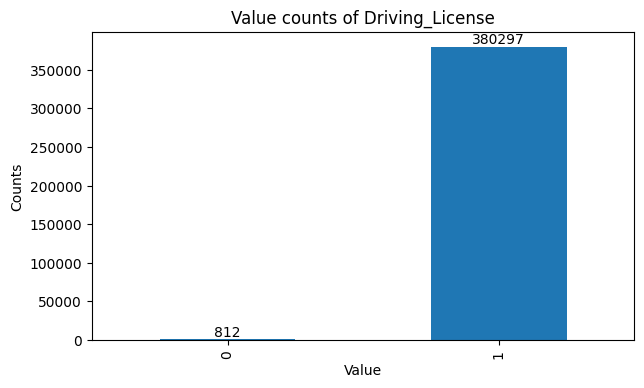

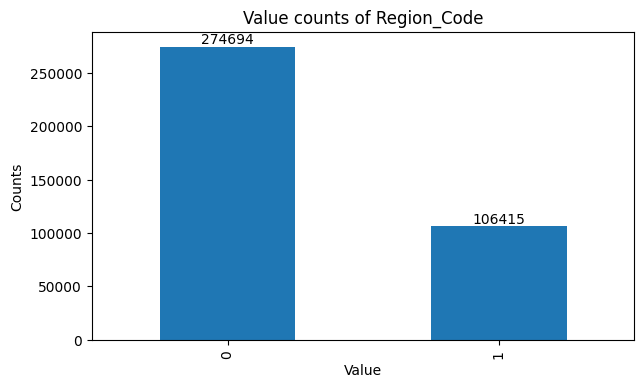

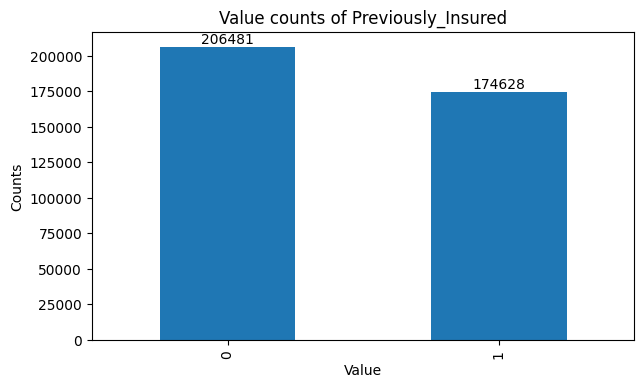

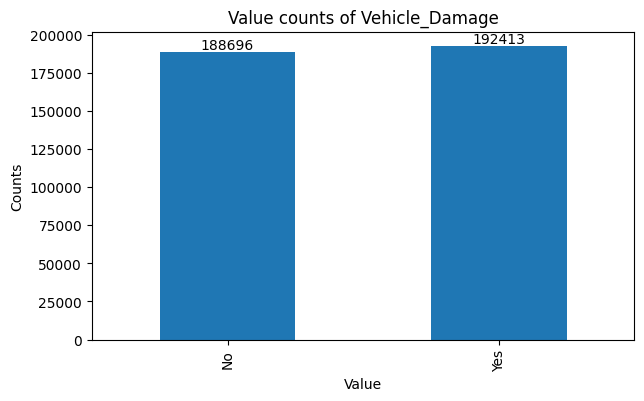

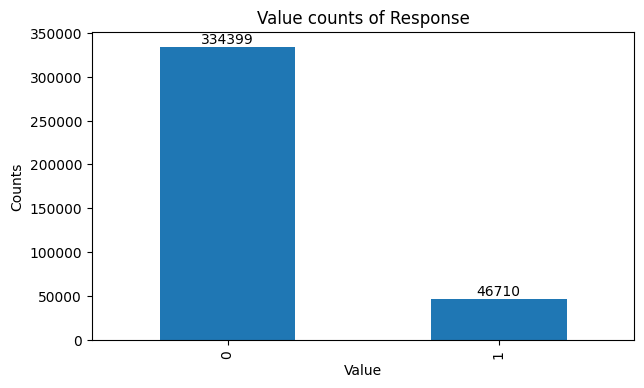

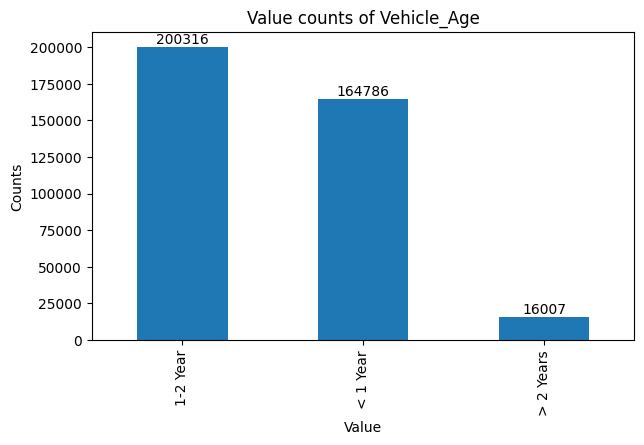

In [ ]:
cols_1 = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Response', 'Vehicle_Age']

for i in cols_1:
  plt.figure(figsize=(7, 4))
  ax = data.groupby(i).size().plot(kind='bar')

  for container in ax.containers:
    ax.bar_label(container, label_type='edge')

  plt.title(f'Value counts of {i}')
  plt.xlabel('Value')
  plt.ylabel('Counts')
  plt.show()

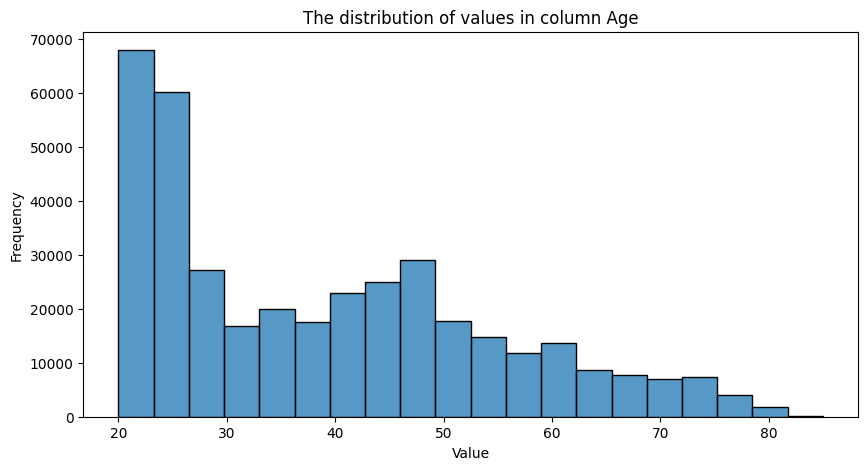

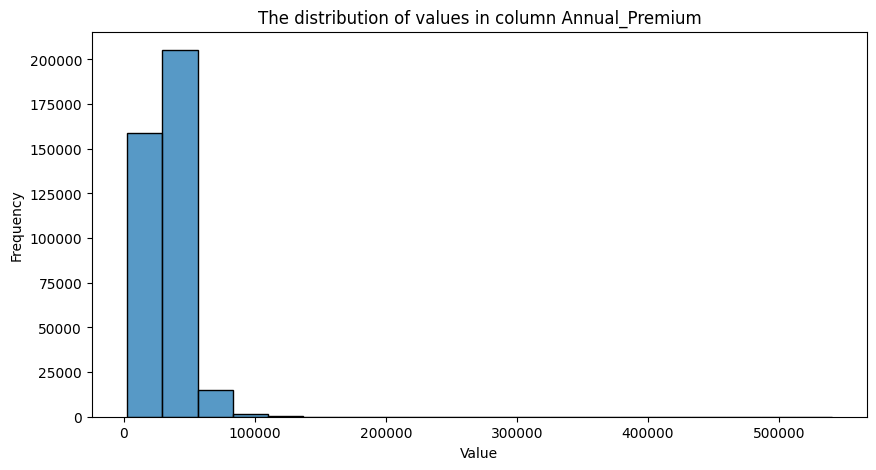

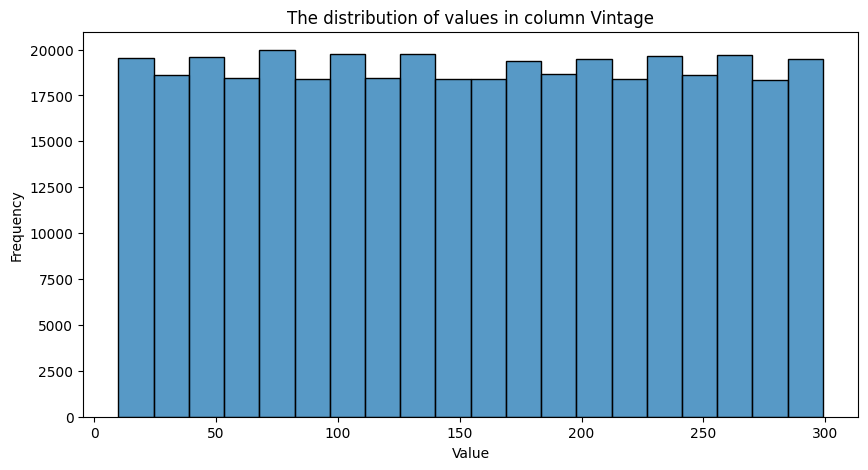

In [ ]:
cols_2 = ['Age', 'Annual_Premium', 'Vintage']

for i in cols_2:
  plt.figure(figsize=(10, 5))
  sns.histplot(data[i], bins=20, edgecolor='black')
  plt.title(f'The distribution of values in column {i}')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()

**C.FEATURES SELECTION-ENCODING**

***One hot coding cho các column "Gender", "Vehicle_Age", "Vehicle_Damage"***

*Các columns này có ít giá trị, vì vậy dùng OHC là hợp lý nhất*

In [5]:
data = pd.get_dummies(data, columns=["Gender", "Vehicle_Age", "Vehicle_Damage"], drop_first=True)

**Corr Matrix**

*Dùng để nhìn xem có cặp columns nào có mối quan hệ tuyến tính cao không. Nhìn vào ta thấy không có bất kì 2 cột nào tuyến tính lẫn nhau, như vậy không cần phải loại bỏ thêm cột*

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
Age,1.000000,-0.079782,0.298304,-0.254682,0.067507,-0.001264,0.111147,0.145545,-0.787775,0.220694,0.267534
Driving_License,-0.079782,1.000000,-0.016017,0.014969,-0.011906,-0.000848,0.010155,-0.018374,0.040215,-0.006211,-0.016622
Region_Code,0.298304,-0.016017,1.000000,-0.182873,0.293050,0.000369,0.122609,0.029822,-0.325856,0.147437,0.193135
Previously_Insured,-0.254682,0.014969,-0.182873,1.000000,0.004269,0.002537,-0.341170,-0.081932,0.358773,-0.191352,-0.824143
Annual_Premium,0.067507,-0.011906,0.293050,0.004269,1.000000,-0.000608,0.022575,0.003673,-0.022555,0.061918,0.009349
Vintage,-0.001264,-0.000848,0.000369,0.002537,-0.000608,1.000000,-0.001050,-0.002517,0.002410,0.000600,-0.002064
Response,0.111147,0.010155,0.122609,-0.341170,0.022575,-0.001050,1.000000,0.052440,-0.209878,0.109300,0.354400
Gender_Male,0.145545,-0.018374,0.029822,-0.081932,0.003673,-0.002517,0.052440,1.000000,-0.166280,0.043155,0.091606
Vehicle_Age_< 1 Year,-0.787775,0.040215,-0.325856,0.358773,-0.022555,0.002410,-0.209878,-0.166280,1.000000,-0.182750,-0.370778
Vehicle_Age_> 2 Years,0.220694,-0.006211,0.147437,-0.191352,0.061918,0.000600,0.109300,0.043155,-0.182750,1.000000,0.206961


**D.DATA PREDICTION**

In [6]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

In [7]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = data.drop(columns=['Response'], axis=1)
    y = data['Response']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # MinMax Scaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

***1.Random Forest***

*Mặc dù số liệu rất cao, nhưng dựa vào tập train, ta thấy có vẻ như đang bị Overfitting do mô hình đang cố học thuộc dữ liệu, và tập test thì hiệu suất rất thấp, do vậy mô hình này không đáng tin cho lắm*

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_RF= RandomForestClassifier(n_estimators=200, random_state=42)
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    267700
           1       0.99      0.96      0.97     37187

    accuracy                           0.99    304887
   macro avg       0.99      0.98      0.98    304887
weighted avg       0.99      0.99      0.99    304887

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     66699
           1       0.32      0.15      0.21      9523

    accuracy                           0.85     76222
   macro avg       0.60      0.55      0.56     76222
weighted avg       0.82      0.85      0.83     76222



***2.XGBOOST***

*Vẫn không ổn, do chênh lệch hiệu suất 2 tập quá cao*

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_XGB = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    267700
           1       0.82      0.05      0.09     37187

    accuracy                           0.88    304887
   macro avg       0.85      0.52      0.51    304887
weighted avg       0.88      0.88      0.83    304887

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.43      0.02      0.04      9523

    accuracy                           0.87     76222
   macro avg       0.65      0.51      0.49     76222
weighted avg       0.82      0.87      0.82     76222



**3.LIGHT GBM**

*Không ổn*

In [10]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_GBM = lgb.LGBMClassifier(random_state=42, n_estimators = 200)
model_GBM.fit(X_train, y_train)

y_train_pred = model_GBM.predict(X_train)
y_test_pred = model_GBM.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

[LightGBM] [Info] Number of positive: 37187, number of negative: 267700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121970 -> initscore=-1.973908
[LightGBM] [Info] Start training from score -1.973908
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    267700
           1       0.82      0.00      0.01     37187

    accuracy                           0.88    304887
   macro avg       0.85      0.50      0.47    304887
weighted avg       0.87      0.88      0.82    304887

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
     

***OVERSAMPLING VỚI SMOTE***

*Lớp 0 thì ổn, nhưng lớp 1 thì vẫn chưa ổn*

***4.SMOTE VS RANDOM FOREST***

*Vẫn không ổn, vẫn có dấu hiệu Overfitting*

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

smote = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = smote.fit_resample(X_train,y_train)

In [ ]:
#Random Forest sử dụng SMOTE
model_RF2 = RandomForestClassifier(n_estimators=200, random_state=42)
model_RF2.fit(X_train_resample, y_train_resample)

y_train_pred = model_RF2.predict(X_train_resample)
y_test_pred = model_RF2.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267700
           1       1.00      1.00      1.00    267700

    accuracy                           1.00    535400
   macro avg       1.00      1.00      1.00    535400
weighted avg       1.00      1.00      1.00    535400

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     66699
           1       0.30      0.49      0.37      9523

    accuracy                           0.80     76222
   macro avg       0.61      0.66      0.63     76222
weighted avg       0.84      0.80      0.82     76222



***5.SMOTE VS XGBOOST***

*có phần cải thiện hơn đôi chút, vẫn chênh lệch cao nhưng ít nhất ổn hơn các mô hình khác*

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

smote = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = smote.fit_resample(X_train,y_train)

In [ ]:
model_XGB_2 = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_XGB_2.fit(X_train_resample, y_train_resample)

y_train_pred = model_XGB_2.predict(X_train_resample)
y_test_pred = model_XGB_2.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.92      0.72      0.80    267700
           1       0.77      0.93      0.84    267700

    accuracy                           0.83    535400
   macro avg       0.84      0.83      0.82    535400
weighted avg       0.84      0.83      0.82    535400

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     66699
           1       0.29      0.84      0.44      9523

    accuracy                           0.73     76222
   macro avg       0.63      0.78      0.63     76222
weighted avg       0.88      0.73      0.77     76222



***6.NAIVE BAYES***

*Có vẻ ổn nhất, mặc dù hiệu suất không cao*

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

y_train_pred = model_nb.predict(X_train)
y_test_pred = model_nb.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.98      0.67      0.80    267700
           1       0.28      0.90      0.43     37187

    accuracy                           0.70    304887
   macro avg       0.63      0.79      0.61    304887
weighted avg       0.89      0.70      0.75    304887

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     66699
           1       0.29      0.90      0.44      9523

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.89      0.71      0.76     76222



**7.CẢI THIỆN NAIVE BAYES**

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

smote = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = smote.fit_resample(X_train,y_train)

In [ ]:
# Optionally: Hyperparameter tuning using GridSearchCV (though limited for GaussianNB)
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(estimator=model_nb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_resample, y_train_resample)

# Best parameters and best score from GridSearch
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Re-train model with best parameters
best_model_nb = grid_search.best_estimator_
best_model_nb.fit(X_train_resample , y_train_resample )

# Final evaluation
y_test_pred_best = best_model_nb.predict(X_test)
print("Final Test Set Scores with Best Model:")
print_scores(y_test, y_test_pred_best)

Best Parameters: {'var_smoothing': 0.02310129700083159}
Best Cross-Validation Accuracy: 0.7842566305565932
Final Test Set Scores with Best Model:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66699
           1       0.26      0.98      0.40      9523

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222

